In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.base import BaseEstimator
import gensim 
from nltk.corpus import stopwords
from scipy import stats
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
import re
from nltk.corpus import stopwords
from gensim import corpora
from sklearn.svm import SVC
stop_words = stopwords.words("english")
plt.style.use('seaborn-whitegrid')

This data originally came from Crowdflower's [Data for Everyone library](http://www.crowdflower.com/data-for-everyone).

As the original source says,

> We looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do both sentiment analysis and data categorization. Contributors were asked which candidate was mentioned, and what the sentiment was for a given tweet. 

In [68]:
# load dataset 
tweets = pd.read_csv('input/Sentiment.csv', parse_dates=['tweet_created'])
tweets.sample(5)

,Unnamed: 0,id,candidate,sentiment,name,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
4116,4116,4117,Marco Rubio,Positive,susangallo,4,"RT @EliRubenstein: The consensus is clear, @Ma...",NaN,2015-08-07 09:10:56-07:00,629686167915626496,"Naples, FL USA",NaN
9408,9408,9409,No candidate mentioned,Negative,Destinbeach22,43,RT @RWSurferGirl: I need to order another gree...,NaN,2015-08-06 20:29:13-07:00,629494477355270144,NaN,Central Time (US & Canada)
3642,3642,3643,No candidate mentioned,Negative,NotDBordwell,0,Legitimacy of TV news 2015: last night Jon Ste...,NaN,2015-08-07 09:16:32-07:00,629687577063198721,"Not Madison, Wisconsin",Central Time (US & Canada)
7975,7975,7976,No candidate mentioned,Neutral,honolulujack,0,GOP Candidates Throw Out Their Best Hillary Cl...,NaN,2015-08-07 08:13:34-07:00,629671730965954564,Hawaii,Hawaii
11330,11330,11331,No candidate mentioned,Negative,CraneRhonda,132,RT @RWSurferGirl: Is it just me or does anyone...,NaN,2015-08-06 19:38:56-07:00,629481823366545408,NaN,NaN


In [3]:
print(f"dataset contains {tweets.shape[0]} tweets and {tweets.shape[1]} predictor variables.")

dataset contains 13871 tweets and 12 predictor variables.


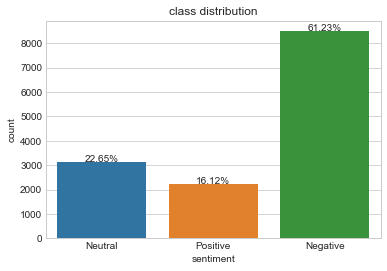

In [4]:
plt.figure()
ax = plt.axes()
sns.countplot(tweets.sentiment)

total_tweets = len(tweets)
plt.title('class distribution')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+20,
            f'{int(height)/total_tweets:.2%}',
            ha="center", fontsize=10)
    
plt.show()

In [5]:
contingency_table = pd.crosstab(tweets.candidate, tweets.sentiment)
contingency_table['negative_proportion'] = contingency_table.Negative/contingency_table.sum(axis=1)
contingency_table

sentiment,Negative,Neutral,Positive,negative_proportion
candidate,,,,
Ben Carson,186,54,164,0.460396
Chris Christie,218,42,33,0.744027
Donald Trump,1758,446,609,0.624956
Jeb Bush,589,72,44,0.835461
John Kasich,82,47,113,0.338843
Marco Rubio,105,51,119,0.381818
Mike Huckabee,237,83,73,0.603053
No candidate mentioned,4724,2087,680,0.630623
Rand Paul,148,60,55,0.562738


The candidate `Donald Trump` has the highest number of negative tweets. However, if we look at the total number of tweet per candidate we can see that `Jeb Bush` has almost 84% of the tweets mentioning him as negative.

**What kind of tweets are the most retweeted?**

In [6]:
tweets.groupby('sentiment').sum()['retweet_count']

sentiment
Negative    419335.0
Neutral     117243.0
Positive     98760.0
Name: retweet_count, dtype: float64

Negative tweets are more than 4 times retweeted than positive tweets. 

**Who are the most retweeted candidates?**

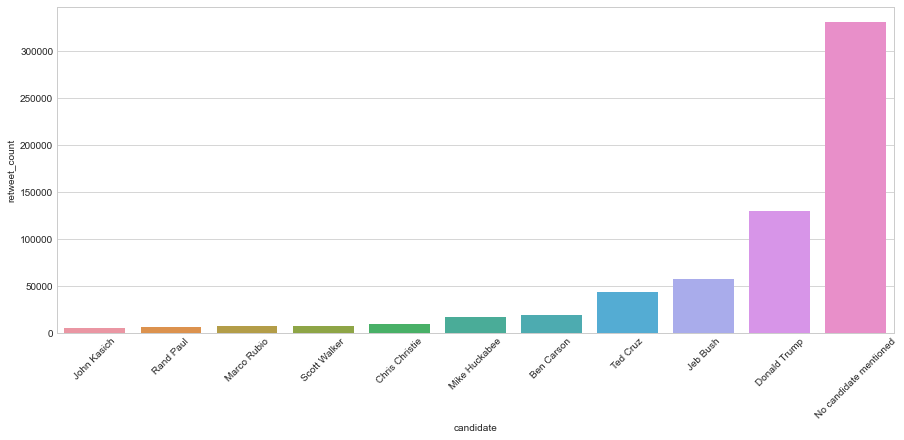

In [7]:
most_rt_candidates = tweets.groupby('candidate').sum()['retweet_count'].sort_values()
plt.figure(figsize=(15,6))
sns.barplot(most_rt_candidates.index, most_rt_candidates)
plt.xticks(rotation=45)
plt.show()

Let us have a look at the time variable `tweet_created`

In [8]:
start_date = tweets.tweet_created.sort_values().iloc[0]
end_date = tweets.tweet_created.sort_values().iloc[-1]
start_date, end_date, (end_date - start_date), start_date.day_name(), end_date.day_name()

(Timestamp('2015-08-06 17:44:53-0700', tz='pytz.FixedOffset(-420)'),
 Timestamp('2015-08-07 10:12:32-0700', tz='pytz.FixedOffset(-420)'),
 Timedelta('0 days 16:27:39'),
 'Thursday',
 'Friday')

We can conclude that the tweets recording lasted for 16hours and ~28 minute. The recodring started Thursday, august 2015 at 17:44 until friday, august 2015 at 10:12.

**How are tweets distributed accros the day? is there any time slot that has more tweets than others?**

In [9]:
tweets_ordered_bytime = tweets.sort_values(by='tweet_created')

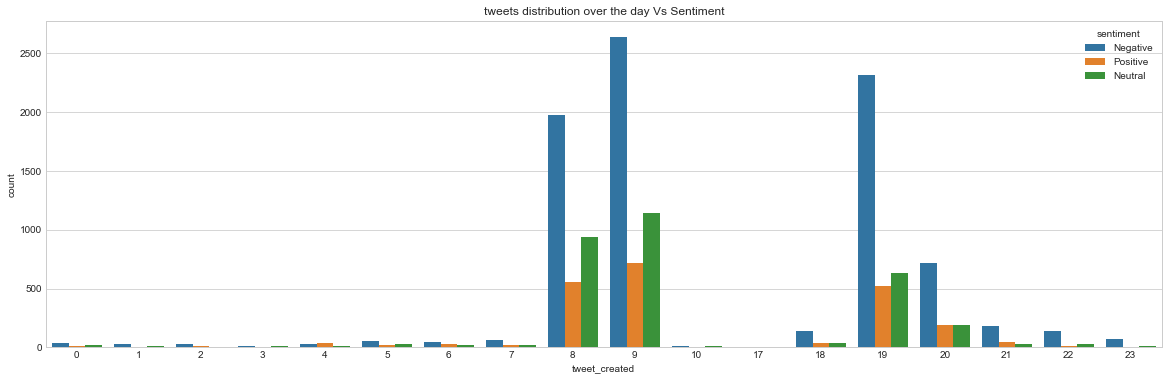

In [10]:
plt.figure(figsize=(20,6))
sns.countplot(tweets_ordered_bytime.tweet_created.dt.hour, hue=tweets_ordered_bytime.sentiment)
plt.title('tweets distribution over the day Vs Sentiment')
plt.show()

We might one to add a new predictor variable that stores the hour of the day or maybe categorigal variable with the following enumeration: morning, afternoon, evening, night

## Missing values

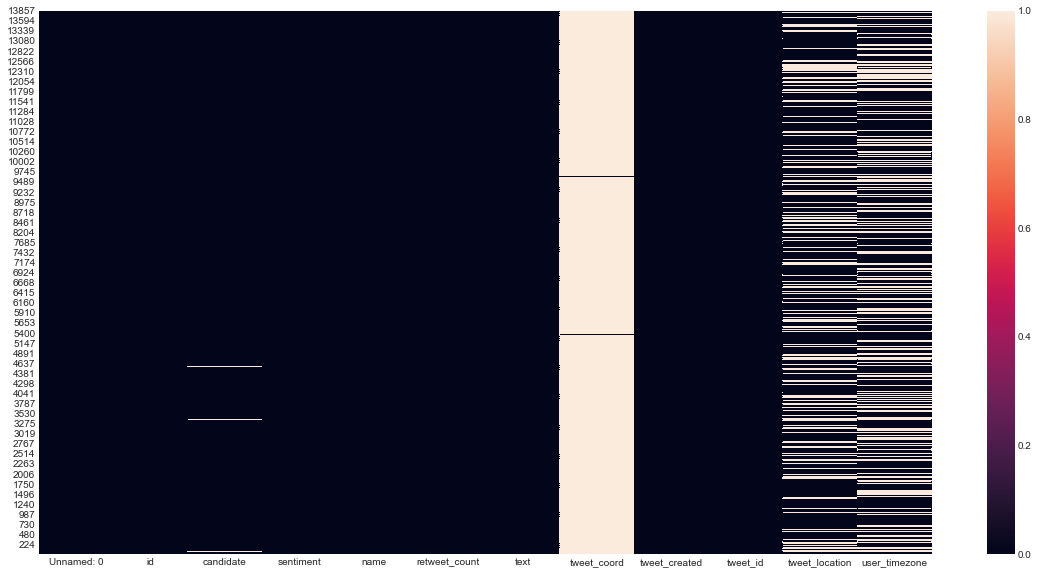

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(tweets_ordered_bytime.isna())
plt.show()

`Tweet_location` and `user_timezone` contain a lot of missing values.
- add new boolean is_nan + impuatation most freq ?

As to `tweet_coord` we will simply drop it.

In [12]:
tweets.drop(columns=['tweet_coord'], inplace=True)

In [13]:
tweets.tweet_location.isna().sum()/len(tweets), tweets.user_timezone.isna().sum()/len(tweets)

(0.28202725109941607, 0.3174248431980391)

Tweet_location and user_timezone are composed of neary 30% of missing of values.

In [14]:
def is_feature_important(feature, target, alpha=.05):
    crosstable = pd.crosstab(target,feature) 
    chi2, p, dof, expected = stats.chi2_contingency(crosstable.values)
    
    return p < alpha

In [15]:
is_feature_important(tweets.user_timezone, tweets.sentiment), is_feature_important(tweets.tweet_location, tweets.sentiment)

(True, True)

- Tweet_location and user_timezone are correlated with the target variable accorind to kh2 test of independance.

## Tweet's text

Let's print some tweets and see how they look

In [16]:
tweets.text.sample(2).to_list()

['@realDonaldTrump lives to fight another day. Odds seem to ever be in his favor. #GOPDebate #hungergames #DonaldTrump http://t.co/eG6X6onkKT',
 'RT @RWSurferGirl: I need to order another green apple martini to process what the hell just happened. 🇺🇸 #GOPDebate  #GOPDebates']

Before analyzing tweets some cleaning has to be performed:
- remove special caracters.
- remove links


In [22]:
def pre_process_tweets(tweet):
    tweet = tweet.replace('RT', '').replace('@', '').replace('#', '')
    
    # remove links
    tweet = re.sub(r'http[s]*\S+', '', tweet)
    
    tokens = word_tokenize(tweet)
    
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token.lower() for token in tokens]
    # no lemmatization or stemming since we are going to use pre-trained embeddings
    
    
    # delete stop words
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

tweets['tokens'] = tweets.text.apply(pre_process_tweets)

## Topic modeling

In [23]:
# Create dictionary
dictionary = corpora.Dictionary(tweets.tokens)
print(dictionary)

Dictionary(13630 unique tokens: ['change', 'climate', 'everyone', 'exactly', 'feel']...)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel

# Instantiate the TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=False, analyzer=lambda x: x)

# Compute the TF-IDF
tf_idf = vectorizer.fit_transform(tweets['tokens'])

# Convert the TF-IDF to the needed input for Gensim
tf_idf_sklearn = Sparse2Corpus(tf_idf, documents_columns=False)

# Compute the LDA
lda2 = LdaModel(corpus=tf_idf_sklearn, id2word=dictionary, num_topics=3, passes=10)

# Print the main topics
pprint(lda2.print_topics())

In [ ]:
# Import the modules
import pyLDAvis
import pyLDAvis.gensim

bow = [dictionary.doc2bow(token) for token in tweets.tokens]

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=lda2, corpus=bow, dictionary=dictionary)
vis

It is not easy to intuitevely see what are the underlying topics from LDA results.

In [27]:
tweets

,Unnamed: 0,id,candidate,sentiment,name,retweet_count,text,tweet_created,tweet_id,tweet_location,user_timezone,tokens
0,0,1,No candidate mentioned,Neutral,I_Am_Kenzi,5,RT @NancyLeeGrahn: How did everyone feel about...,2015-08-07 09:54:46-07:00,629697200650592256,NaN,Quito,"[nancyleegrahn, everyone, feel, climate, chang..."
1,1,2,Scott Walker,Positive,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46-07:00,629697199560069120,NaN,NaN,"[scottwalker, catch, full, gopdebate, last, ni..."
2,2,3,No candidate mentioned,Neutral,PussssyCroook,27,RT @TJMShow: No mention of Tamir Rice and the ...,2015-08-07 09:54:46-07:00,629697199312482304,NaN,NaN,"[tjmshow, mention, tamir, rice, gopdebate, hel..."
3,3,4,No candidate mentioned,Positive,MattFromTexas31,138,RT @RobGeorge: That Carly Fiorina is trending ...,2015-08-07 09:54:45-07:00,629697197118861312,Texas,Central Time (US & Canada),"[robgeorge, carly, fiorina, trending, hours, d..."
4,4,5,Donald Trump,Positive,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45-07:00,629697196967903232,NaN,Arizona,"[danscavino, gopdebate, realdonaldtrump, deliv..."
...,...,...,...,...,...,...,...,...,...,...,...,...
13866,13866,13867,No candidate mentioned,Negative,SantoliDonato,7,RT @cappy_yarbrough: Love to see men who will ...,2015-08-07 09:29:43-07:00,629690895479250944,Como,NaN,"[love, see, men, never, faced, pregnancy, talk..."
13867,13867,13868,Mike Huckabee,Positive,mhfa16hq,1,RT @georgehenryw: Who thought Huckabee exceede...,2015-08-07 09:25:02-07:00,629689719056568320,USA,NaN,"[georgehenryw, thought, huckabee, exceeded, ex..."
13868,13868,13869,Ted Cruz,Positive,DrottM,67,"RT @Lrihendry: #TedCruz As President, I will a...",2015-08-07 07:19:18-07:00,629658075784282112,NaN,NaN,"[lrihendry, tedcruz, president, always, tell, ..."
13869,13869,13870,Donald Trump,Negative,danijeantheq,149,RT @JRehling: #GOPDebate Donald Trump says tha...,2015-08-07 09:54:04-07:00,629697023663546368,NaN,NaN,"[jrehling, gopdebate, donald, trump, says, tim..."


In [31]:
tweets_complexity = pd.DataFrame()
tweets_complexity['tweet_len'] = tweets.text.str.len()
tweets_complexity['num_words'] = tweets.tokens.str.len()
tweets_complexity['nunique_words'] = tweets.tokens.apply(set).str.len()
tweets_complexity['words_diversity'] = tweets_complexity['nunique_words'] / tweets_complexity['num_words'] 
tweets_complexity['sentiment'] = tweets.sentiment
tweets_complexity.sample(5)

,tweet_len,num_words,nunique_words,words_diversity,sentiment
9955,144,11,11,1.000000,Positive
5262,130,19,19,1.000000,Negative
6191,131,11,11,1.000000,Negative
2160,131,15,14,0.933333,Negative
7414,139,11,11,1.000000,Negative


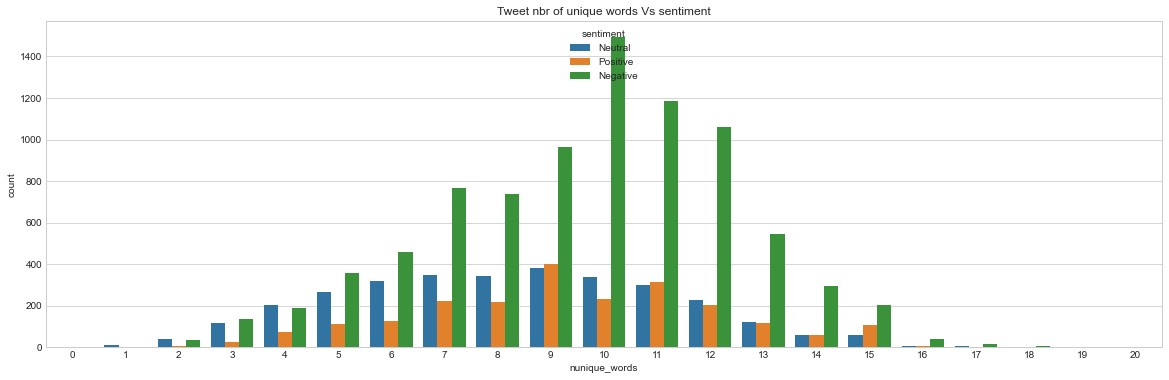

In [32]:
plt.figure(figsize=(20,6))
sns.countplot(tweets_complexity.nunique_words, hue=tweets_complexity.sentiment)
plt.title('Tweet nbr of unique words Vs sentiment')
plt.show()

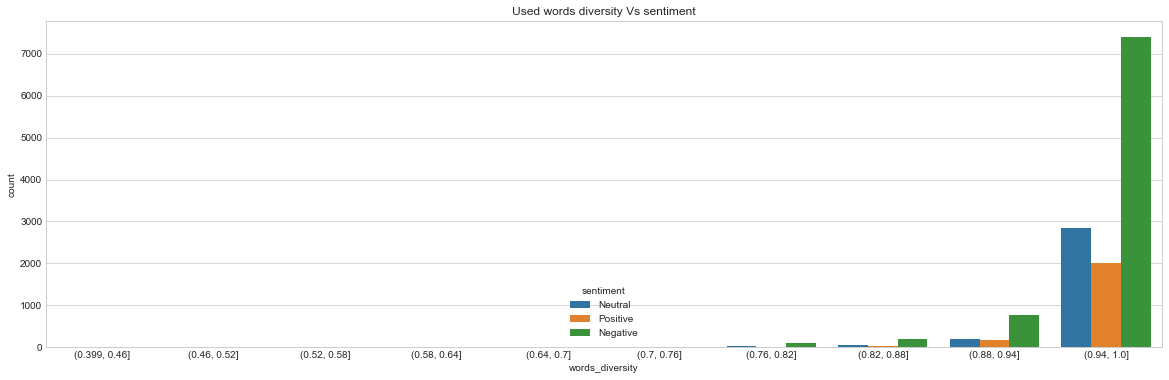

In [33]:
plt.figure(figsize=(20,6))
sns.countplot(pd.cut(tweets_complexity.words_diversity, 10), hue=tweets_complexity.sentiment)
plt.title('Used words diversity Vs sentiment')
plt.show()

## tweet_created

let's create four categories out of tweet_created.

- Noon: from 6:00 to 12:00 
- Afternoon: from 12:01 to 17:00
- Evening: from 17:01 to 20:00
- Night: from 20:01 to 5:59

In [36]:
def mapping_func(hour):
    if 6 < hour <= 12:
        return 'Noon'
    elif 12 < hour <= 17:
        return 'Afternoon'
    elif 17 < hour <= 20:
        return 'Evening' 
    else:
        return 'Night'
period_of_day = tweets.tweet_created.dt.hour.apply(mapping_func)

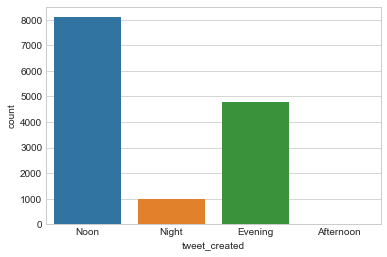

In [37]:
sns.countplot(period_of_day);

People tend to tweet more in the morning as well as in the evening before going to bed.

## Sentiment

Let's encode our classes into numerical values.

In [69]:
target_encoder = LabelEncoder()
y = pd.Series(target_encoder.fit_transform(tweets.sentiment))

As we saw in EDA ~30% of these two features is composed of missing values. Let's consider the missing value as another category therefore we will impute it -999.

Let's create two other feature, user_timezone_isna and tweet_location_isna which will hold a boolean value to indictate to the model the rows containing missing values respectively for user_timezone and tweet_location.

In [70]:
tweets['user_timezone_isna'] = tweets.user_timezone.isna().astype(int)
tweets['tweet_location_isna'] = tweets.tweet_location.isna().astype(int)
tweets['user_timezone'] = tweets.user_timezone.fillna(-999)
tweets['tweet_location'] = tweets.tweet_location.fillna(-999)

## Candidate

In [40]:
tweets.candidate.isna().sum()

96

When a candidate is not mentionned, the tweet is put in 'No candidate mentioned'. Therefore, I will consider the missing candidate values to be part of 'No candidate mentioned' category.

In [77]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
tweets['candidate'] = imputer.fit_transform(tweets['candidate'].values.reshape(-1, 1))

## Data split

Our final dataset will be composed of the following features: user_timezone_isna, tweet_location_isna, user_timezone, tweet_location, text embeddings, retweet_count and candidate

In [71]:
boolean_features = ['user_timezone_isna', 'tweet_location_isna']
categorical_features = ['candidate', 'user_timezone', 'tweet_location']
numerical_features = ['retweet_count']
embeddings = ['text']

In [72]:
tweets[boolean_features+categorical_features+numerical_features+embeddings].sample(5)

,user_timezone_isna,tweet_location_isna,candidate,user_timezone,tweet_location,retweet_count,text
13010,0,1,Mike Huckabee,Central Time (US & Canada),-999,60,RT @goldietaylor: Huckabee. #GOPDebates http:/...
1654,0,1,No candidate mentioned,Pacific Time (US & Canada),-999,0,"Even the media doesn't get it, No one won las..."
2157,0,0,No candidate mentioned,Mountain Time (US & Canada),Canada,1,"lol! Of course you do. RT""@sallykohn: I thin..."
7881,1,1,No candidate mentioned,-999,-999,50,"RT @goldietaylor: Oh, hell. Just take a drink...."
481,1,0,No candidate mentioned,-999,"El Paso, Texas",0,#GOPDebate so which presidential candidate stu...


In [78]:
from sklearn.model_selection import train_test_split

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(tweets[boolean_features+categorical_features+numerical_features+embeddings], y, test_size=.2,
                               stratify=y, random_state=SEED)

# Pipeline

For the categorical variable, I suggest that we count encode them. Basically we will replace each categorie by it's number of occurences.

In [74]:
class Doc2Vec(BaseEstimator):

    def __init__(self, vector_size=50, min_count=2, epochs=40):        
        self.vector_size=vector_size
        self.min_count=min_count
        self.epochs=epochs
        
    def __pre_process(self, X, train_tag=True):
        X_tr = X.copy()
        X_tr = X_tr.text.str.replace('RT', '').str.replace('@', '').str.replace('#', '')

        # remove links
        X_tr = X_tr.str.replace(r'http[s]*\S+', '')

        X_tr = X_tr.apply(word_tokenize)

        X_tr = [[token.lower() for token in tokens if token.isalpha()] for tokens in X_tr]
        X_tr = [[token.lower() for token in tokens] for tokens in X_tr]
        # no lemmatization or stemming since we are going to use pre-trained embeddings


        # delete stop words
        X_tr = [[token.lower() for token in tokens if token not in stop_words] for tokens in X_tr]
        
        X_tag = []
        for i, doc in enumerate(X_tr):
                # For training data, add tags
                if train_tag:
                    X_tag.append(gensim.models.doc2vec.TaggedDocument(doc, [i]))
                else:
                    X_tag.append(doc)
        
        return list(X_tag)
    
    def fit(self, X_train, y=None):
        self.model = gensim.models.doc2vec.Doc2Vec(vector_size=self.vector_size, min_count=self.min_count, epochs=self.epochs)
        X_train_tag = self.__pre_process(X_train)
        self.model.build_vocab(X_train_tag) 
        self.model.train(X_train_tag, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        
        return self

    def transform(self, X):
        X_tr = self.__pre_process(X, train_tag=False)
        doc2vec_embeddings = np.array([self.model.infer_vector(doc) for doc in X_tr])
        
        return doc2vec_embeddings

class CountEncoder(BaseEstimator):

    def __init__(self, normalize=True):
        self.normalize = normalize

    def fit(self, X_train, y=None):
        self.__set_mapping(X_train)
        
        return self

    def transform(self, X):
        X_tr = X.copy()

        if type(X) != type(pd.DataFrame()): 
            raise ValueError(f'{type(X)} not supported')
        
        col_id = 0
        for col, serie in  X.iteritems():
            X_tr[col] = serie.map(self.mapping_list[col_id])
            col_id += 1
        
        return X_tr

    def __set_mapping(self, X):
        if type(X) != type(pd.DataFrame()):
            raise ValueError(f'{type(X)} not supported')

        self.mapping_list = []
        for col, serie in X.iteritems():
            if self.normalize:
                self.mapping_list.append((serie.value_counts()/serie.value_counts().max()).to_dict())
            else:
                self.mapping_list.append(serie.value_counts().to_dict())

In [81]:
static_params = {
    'objective': 'multi:softmax',
    'boosting_type': 'gbdt',
    'num_class': 3,
    'max_depth': 5
}


feature_engineering = ColumnTransformer([('CountEncoder', CountEncoder(), categorical_features),
                                         ('doc2vec', Doc2Vec(), embeddings)],
                                         remainder='passthrough', verbose=0)

steps = [('feature_engineering', feature_engineering),
         ('model', XGBClassifier(**static_params))
        ]

model = Pipeline(steps)
    


model.fit(X_train, y_train)

[16:05:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { boosting_type } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Pipeline(steps=[('feature_engineering',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('CountEncoder',
                                                  CountEncoder(),
                                                  ['candidate', 'user_timezone',
                                                   'tweet_location']),
                                                 ('doc2vec', Doc2Vec(),
                                                  ['text'])],
                                   verbose=0)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               boosting_type='gbdt', colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1

In [82]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.89      0.77      1699
           1       0.45      0.22      0.29       629
           2       0.55      0.31      0.39       447

    accuracy                           0.64      2775
   macro avg       0.56      0.47      0.49      2775
weighted avg       0.61      0.64      0.60      2775



In [83]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      6794
           1       0.76      0.44      0.56      2513
           2       0.81      0.53      0.64      1789

    accuracy                           0.76     11096
   macro avg       0.77      0.64      0.68     11096
weighted avg       0.77      0.76      0.75     11096



The model performed badly, maybe this is caused by class imbalance. Let's use SMOTE to create synthetic embeddings.

## Create synthetic tweets by applying SMOTE on tweets embeddings

In [87]:
static_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 5
}


feature_engineering = ColumnTransformer([('CountEncoder', CountEncoder(), categorical_features),
                                         ('doc2vec', Doc2Vec(), embeddings)],
                                         remainder='passthrough', verbose=0)
strategy = {0:6794, 1:6794, 2:6794}

X_train_tr = feature_engineering.fit_transform(X_train, y_train)
sm = SMOTE(sampling_strategy=strategy)
X_train_tr_res, y_train_res = sm.fit_resample(X_train_tr, y_train)

model = XGBClassifier(**static_params)

model.fit(X_train_tr_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
print(classification_report(y_test, model.predict(feature_engineering.transform(X_test))))

              precision    recall  f1-score   support

           0       0.71      0.79      0.74      1699
           1       0.40      0.33      0.36       629
           2       0.50      0.40      0.44       447

    accuracy                           0.62      2775
   macro avg       0.53      0.50      0.51      2775
weighted avg       0.60      0.62      0.61      2775



In [89]:
print(classification_report(y_train_res, model.predict(X_train_tr_res)))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      6794
           1       0.91      0.92      0.91      6794
           2       0.94      0.94      0.94      6794

    accuracy                           0.93     20382
   macro avg       0.93      0.93      0.93     20382
weighted avg       0.93      0.93      0.93     20382



- the model has over-fitted the data, and has not generalized well.

The model performs poorly, it could be that the the number of samples is not sufficient for the model to perform better. 

Options to consider in order to improve the model performance:

- perform a grid search to optimize hyper-parameters
- feature engineering